In [66]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from delensalot.sims.sims_lib import Xunl, Xsky
import cunusht
import delensalot
from IPython.display import clear_output
import os
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

planck_cmap = ListedColormap(np.loadtxt(os.path.dirname(delensalot.__file__)+"/data/Planck_Parchment_RGB.txt")/255.)
planck_cmap.set_bad("gray")
planck_cmap.set_under("white") 

lmax, mmax = 2047+1024, 2047+1024
geominfo = ('gl',{'lmax':lmax})
kwargs = {
    'geominfo_deflection':  geominfo,
}

t = cunusht.get_transformer(backend='CPU')(**kwargs)

def gauss(x, mu, sigma):
    # Since we're doing a discrete distribution, we'll normalize later. We don't need to add a 1/sigma/sqrt(2*pi) here.
    return np.exp(-(x-mu)**2/(2*sigma**2))

def get_ptg(toydlm=None, n=1):
    if toydlm is None:
        _t, _p = t.dlm2pointing(np.zeros(hp.Alm.getsize(lmax, lmax), dtype=np.complex), mmax_dlm=lmax, single_prec=False, nthreads=10).T
        _ptgpnod = _p.reshape(lmax+1,-1).flatten()
        _ptgtnod = _t.reshape(lmax+1,-1).flatten()
        # ptgpslice = (_p.reshape(lmax+1,-1)+0.1*1).flatten()#*np.sin(4/10*np.linspace(0,2*np.pi,2048)).reshape(-1, 1)).flatten()
        # ptgtslice = (_t.reshape(lmax+1,-1)+0.01*np.sin(8/10*np.linspace(0,2*np.pi,4096))).flatten()

        # ptgpslice = (_p.reshape(lmax+1,-1)+0.05*np.sin(n*2*np.pi/10) + 0.01).flatten()#nnp.sin(4*np.sqrt(n)/10*np.linspace(0,2*np.pi,4096))).flatten()
        # ptgtslice = (_t.reshape(lmax+1,-1)+0.01*np.sin(8*np.sqrt(n)/10*np.linspace(0,2*np.pi,4096))).flatten()

        # This is for jupiter (Planet)
        ptgpslice = (_p.reshape(lmax+1,-1)+np.sin(2*np.pi*n/80)*0.05*np.sin(6*np.linspace(0,np.pi,lmax+1).reshape(-1,1)+n*np.pi/8)+0.04).flatten()
        ptgtslice = (_t.reshape(lmax+1,-1)).flatten()

        ptgtslice = np.where(ptgtslice>np.pi,ptgtslice-np.pi, ptgtslice)
        ptgtslice = np.where(ptgtslice<0,ptgtslice+np.pi, ptgtslice)
        ptgpslice = np.where(ptgpslice>2*np.pi,ptgpslice-2*np.pi, ptgpslice)
        ptgpslice = np.where(ptgpslice<0,ptgpslice+2*np.pi, ptgpslice)

        _ptg = np.array([ptgtslice, ptgpslice]).T
        _ptgnod = np.array([_ptgtnod, _ptgpnod]).T
    else:
        _tnod, _pnod = t.dlm2pointing(np.zeros(hp.Alm.getsize(lmax, lmax), dtype=np.complex), mmax_dlm=lmax, single_prec=False, nthreads=10).T
        _t, _p = t.dlm2pointing(toydlm, mmax_dlm=lmax, single_prec=False, nthreads=10).T
        _ptg = np.array([_t, _p]).T
        _ptgnod = np.array([_tnod, _pnod]).T
    return _ptg, _ptgnod

Did not set up lensing, as at least one parameter was missing


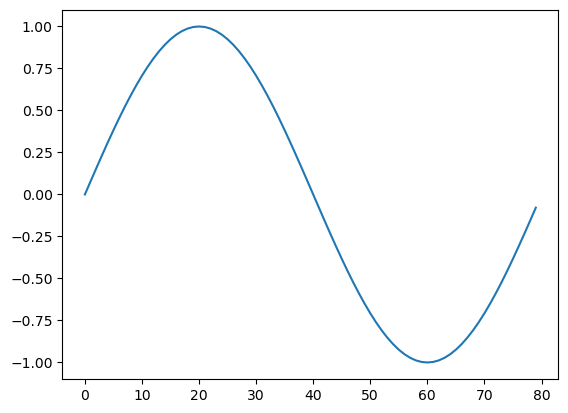

In [67]:
n = np.arange(0,80)
plt.plot(np.sin(n*2*np.pi/80))

# Test interface

## Different toydlms

/tmp/ipykernel_575622/3696927867.py:3: RuntimeWarning: divide by zero encountered in divide
  cl = 1e-3*(1 - 1*np.sin(0.2*l)**4)/(l*(l+1))**2
/tmp/ipykernel_575622/3696927867.py:6: RuntimeWarning: divide by zero encountered in divide
  cl = np.where(cl<1e-10,1e-10,cl)/(l*(l+1))**2


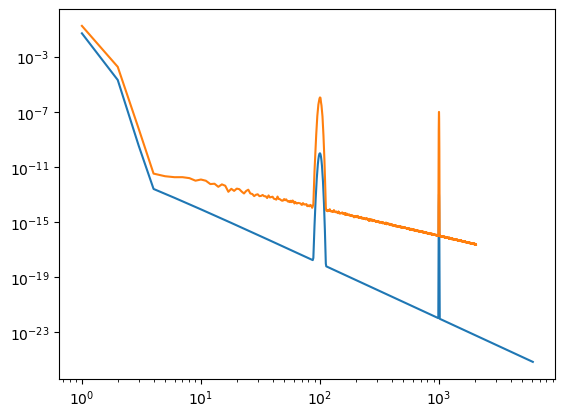

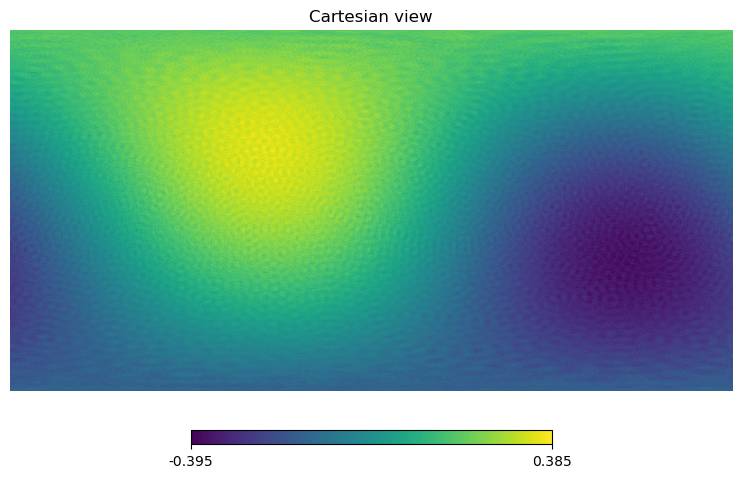

In [9]:
l = np.arange(0,6144)
cl = (10+1e0*np.sin(l))*1e-2*np.exp(-l/200)*1e-15
cl = 1e-3*(1 - 1*np.sin(0.2*l)**4)/(l*(l+1))**2

cl = gauss(l, 0.1, 0.5)*1e0+gauss(l, 100, 2)*1e-2+gauss(l, 1000, 2)*1e-1
cl = np.where(cl<1e-10,1e-10,cl)/(l*(l+1))**2

philm = hp.synalm(cl, lmax=2047)
toydlm = hp.almxfl(philm, np.sqrt(l*(l+1)))
plt.plot(cl)
plt.loglog(hp.alm2cl(toydlm))
plt.show()
hp.cartview(hp.alm2map(np.nan_to_num(toydlm), nside=512))

In [98]:
l = np.arange(0,6144)
synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=lmax)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo, epsilon=1e-10)
philm = synunl.get_sim_phi(0, space='alm')
toydlm = hp.almxfl(philm, np.sqrt(l*(l+1)))*0.6
toyunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')

INFO:: 05-13 15:29:24:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-13 15:29:24:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 05-13 15:29:24:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 05-13 15:29:24:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (4720128,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(18874368,)], types: [<class 'numpy.ndarray'>]


## pointing from toydlm

/tmp/ipykernel_348225/182131388.py:43: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _tnod, _pnod = t.dlm2pointing(np.zeros(hp.Alm.getsize(2047, 2047), dtype=np.complex), mmax_dlm=2047, single_prec=False, nthreads=10).T


deflection std is 0.00e+00 amin
deflection: I set numthreads to 10
 DUCC 10 threads deflection instantiated 1e-14
deflection std is 1.07e+00 amin
deflection: I set numthreads to 10
 DUCC 10 threads deflection instantiated 1e-14


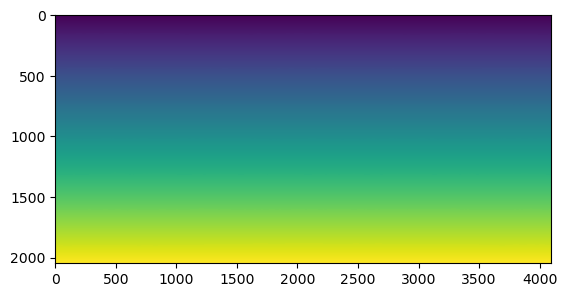

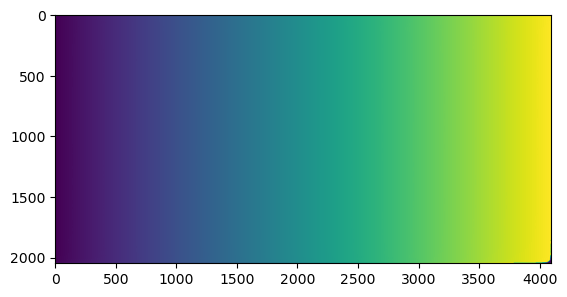

In [17]:
ptg, ptgnod = get_ptg(toydlm)
plt.imshow(ptg[:,0].reshape(lmax+1,-1))
plt.show()
plt.imshow(ptg[:,1].reshape(lmax+1,-1))

In [11]:
mincut, maxcut = 500, 550
dcut = maxcut-mincut
spacing = 1
_ptgtnod, _ptgpnod = t.dlm2pointing(toydlm*1e-12, mmax_dlm=2047, single_prec=False, nthreads=10).T
_ptgpnod = _ptgpnod.reshape(lmax+1,-1)[::spacing,::spacing][mincut:maxcut,mincut:maxcut].flatten()
_ptgtnod = _ptgtnod.reshape(lmax+1,-1)[::spacing,::spacing][mincut:maxcut,mincut:maxcut].flatten()
# _ptgpnod = np.array([np.linspace(0,2*np.pi,4096) for n in range(2048)])[::spacing,::spacing][mincut:maxcut,mincut:maxcut].flatten()
# _ptgtnod = np.array([np.linspace(0,np.pi,2048) for n in range(4096)]).T[::spacing,::spacing][mincut:maxcut,mincut:maxcut].flatten()

ptgpslice = ptg[:,1].reshape(lmax+1,-1)[mincut:maxcut,mincut:maxcut][::spacing,::spacing].flatten()
ptgtslice = ptg[:,0].reshape(lmax+1,-1)[mincut:maxcut,mincut:maxcut][::spacing,::spacing].flatten()

# plt.imshow(_ptgpnod.reshape(dcut,-1))
# plt.show()

# plt.imshow(ptgpslice.reshape(dcut,-1))
# plt.show()

# plt.imshow(_ptgtnod.reshape(dcut,-1))
# plt.show()

# plt.imshow(ptgtslice.reshape(dcut,-1))
# plt.show()


deflection std is 1.07e-12 amin
deflection: I set numthreads to 10
 DUCC 10 threads deflection instantiated 1e-14


(0.8, 0.84)

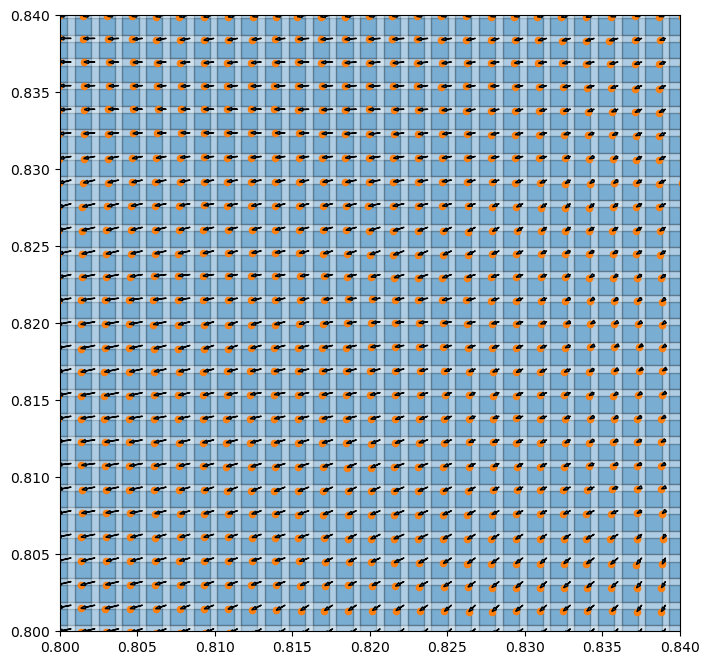

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

plt.scatter(_ptgpnod, _ptgtnod, s=850, marker='s', alpha=0.2, edgecolor='black')
plt.scatter(ptgpslice, ptgtslice, s=20)

# plt.hlines(_ptgtnod, 0, 2*np.pi, color='grey', ls='--', lw=0.1)
# plt.vlines(_ptgpnod, 0, 2*np.pi, color='grey', ls='--', lw=0.1)

spacing = 1
for x,y,dx,dy in zip(_ptgpnod[::spacing], _ptgtnod[::spacing], (ptgpslice-_ptgpnod)[::spacing], (ptgtslice-_ptgtnod)[::spacing]):
    plt.arrow(x, y, dx, dy, length_includes_head=True, head_width=2e-4, width=1e-5)#dx, dy)# head_width=0.0000000005)


plt.xlim(0.8,0.84)
plt.ylim(0.80,0.84)

## run deflection

## Generate Movie

CPU

In [127]:
cmap = planck_cmap
gcls = []
vmin = -4e2 #100
vmax = 4e2 #240
nmax = 240
lonra, latra = [30,50], [30,50]
ll = np.arange(lmax+1)

gclm1 = t.lenspyx_geom.adjoint_synthesis(np.copy(toyunlmap), spin=0, lmax=lmax, mmax=mmax, nthreads=10)[0]
print(gclm1.shape)
gcls.append(hp.alm2cl(gclm1))
hp.mollview(hp.alm2map(gclm1,nside=1024), cbar=None, title=None, min=vmin, max=vmax, cmap=cmap)
plt.savefig('output/movie/figs/fig{:03d}_mollview.png'.format(0))
hp.cartview(hp.alm2map(gclm1,nside=1024), cbar=None, title=None, min=vmin, max=vmax, lonra=lonra, latra=latra, cmap=cmap)
plt.savefig('output/movie/figs/fig{:03d}_cv.png'.format(0))
plt.show()
clear_output()
for n in range(0,nmax):
    print("running n={}".format(n))
    if n == 0:
        m = np.copy(toyunlmap)
    else:
        m = np.copy(res)
    gclm1 = t.lenspyx_geom.adjoint_synthesis(m, lmax=lmax, spin=0, mmax=mmax, nthreads=10)
    gcls.append(hp.alm2cl(gclm1[0]))
    _ptg, _ptgnod = get_ptg(toydlm=None, n=n)
    philm = synunl.get_sim_phi(n, space='alm')
    toydlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))*1.0
    res = t.gclm2lenmap(gclm=gclm1, dlm=toydlm, lmax=lmax, mmax=mmax, spin=0, nthreads=10, epsilon=1e-14)#, ptg=_ptg)

    # plt.imshow(res.reshape(lmax+1,-1)[sl:su,sl:su], vmin=-400, vmax=400)
    gclm1 = t.lenspyx_geom.adjoint_synthesis(np.copy(res), spin=0, lmax=lmax, mmax=mmax, nthreads=10)
    hp.mollview(hp.alm2map(gclm1[0],nside=1024), cbar=None, title=None, min=vmin, max=vmax, cmap=cmap)
    plt.savefig('output/movie/figs/fig{:03d}_mollview.png'.format(n+1))
    plt.show()
    hp.cartview(hp.alm2map(gclm1[0],nside=1024), cbar=None, title=None, min=vmin, max=vmax, lonra=lonra, latra=latra, cmap=cmap)
    plt.savefig('output/movie/figs/fig{:03d}_cv.png'.format(n+1))
    plt.show()
    clear_output()

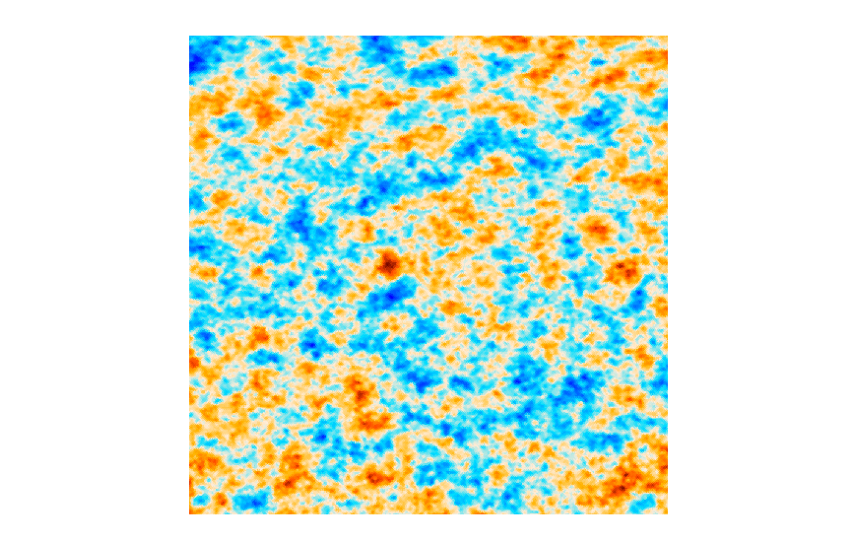

In [129]:
from PIL import Image
image_array = []
import glob
cv = '_cv'
# cv = '_mollview'
files = sorted(glob.glob(r"output/movie/figs/fig*_cv.png")) if cv == '_cv' else sorted(glob.glob(r"output/movie/figs/fig*_mollview.png"))
for my_file in list([*files[:nmax], *files[:nmax][::-1]]):
    image = Image.open(my_file)
    image_array.append(image)

fig, ax = plt.subplots()
fig.set_size_inches(10.8, 8.7)
im = ax.imshow(image_array[0], animated=True, aspect=1, cmap=planck_cmap)
ax.axis('off')

def update(i):
    im.set_array(image_array[i])
    im.set_cmap(planck_cmap)
    clear_output()
    return im, 

animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=1, blit=True,repeat_delay=0)
# plt.show()

animation_fig.save("output/movie/animated_deflection{}.gif".format(cv))
# from IPython.display import HTML
# HTML(animation_fig.to_jshtml())

25


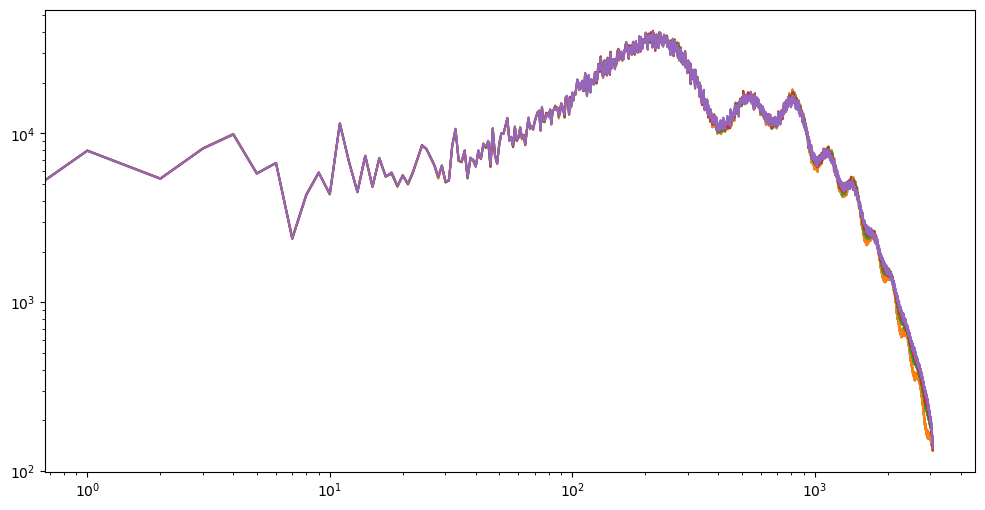

(0.0, 2.0)

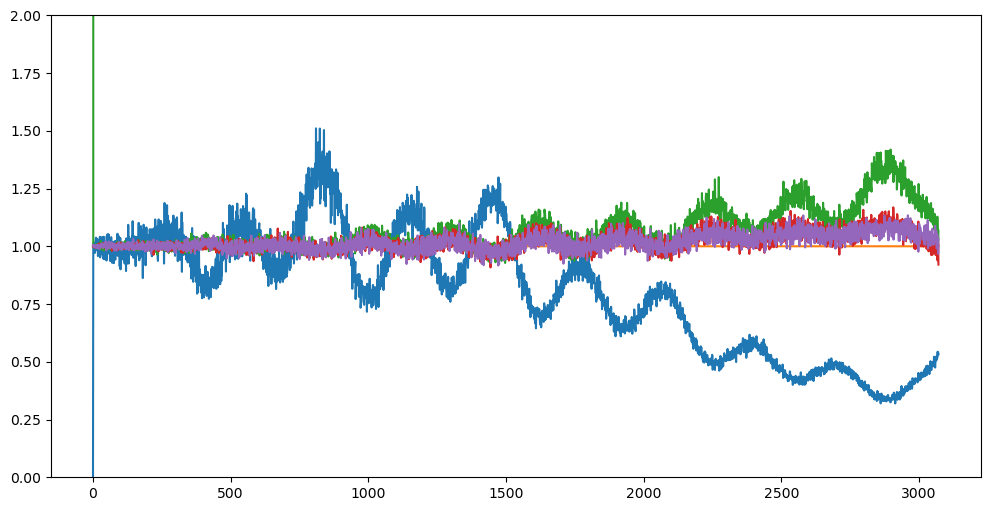

In [125]:
ll = np.arange(0,lmax+1)
# diff = np.array([np.abs(np.mean((gclms[0][0]-gclm[0])/gclm[0])) for gclmi, gclm in enumerate(gclms[1:])])
# plt.plot(diff)
# # plt.loglog()
# plt.show()
print(len(gcls))
fig, ax = plt.subplots(figsize=(12,6))
for gclmi, gclm in enumerate(gcls[:5]):
    # if gclmi in [0,59,60,61]:
    plt.plot(gclm.flatten()*ll*(ll+1))
plt.loglog()
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
for gclmi, gclm in enumerate(gcls[:5]):
    # if gclmi in [0,59,60,61]:
    plt.plot(gcls[gclmi].flatten()/gcls[gclmi-1].flatten())
# plt.ylim(-0.5,0.5)
plt.ylim(0,2)

In [90]:
np.array(gclms).shape

/tmp/ipykernel_613269/2181571102.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(gclms).shape


(25,)

GPU

In [ ]:
toyunlmap = toyunlmap #jupitermap
toyunlmap = toyunlmap.reshape(-1,t.nphi_CAR)
toyunlmap = toyunlmap * t.iw[:,None].get() # TODO replace with shtns_no_weights-flag once it exists
toyunlmap = toyunlmap.T.flatten()


cmap = planck_cmap
gclms = []
vmin = -4e2 #100
vmax = 4e2 #240
nmax = 240

gclm1 = t.lenspyx_geom.adjoint_synthesis(np.copy(toyunlmap), spin=0, lmax=lmax, mmax=mmax, nthreads=10)
gclm1 = cp.empty(hp.Alm.getsize(lmax, mmax), dtype=np.complex128)
gclm1 = t.deflectionlib.adjoint_synthesis(cp.array(toyunlmap.reshape(-1,t.geom.nph[0]).flatten()), spin=0, lmax=lmax, mmax=mmax, nthreads=10, out=gclm1).get()
print(gclm1.shape)
gclms.append(hp.alm2cl(gclm1))
hp.mollview(hp.alm2map(gclm1,nside=1024), cbar=None, title=None, min=vmin, max=vmax, cmap=cmap)
plt.savefig('output/movie/figs/fig{:03d}_mollview.png'.format(0))
hp.cartview(hp.alm2map(gclm1,nside=1024), cbar=None, title=None, min=vmin, max=vmax, lonra=[30,45], latra=[30,45], cmap=cmap)
plt.savefig('output/movie/figs/fig{:03d}_cv.png'.format(0))
plt.show()
clear_output()
for n in range(0,nmax):
    if n == 0:
        m = cp.array(toyunlmap)
    else:
        m = cp.array(res)
    gclm1 = t.deflectionlib.adjoint_synthesis(m, lmax=lmax, mmax=mmax, nthreads=10)
    gclms.append(hp.alm2cl(gclm1))
    _ptg, _ptgnod = get_ptg(toydlm=None, n=n)
    res = t.gclm2lenmap(gclm=gclm1, dlm=toydlm, lmax=lmax, mmax=mmax, spin=0, nthreads=10, epsilon=1e-14)#, ptg=_ptg)

    # plt.imshow(res.reshape(lmax+1,-1)[sl:su,sl:su], vmin=-400, vmax=400)
    gclm1 = t.lenspyx_geom.adjoint_synthesis(np.copy(res), spin=0, lmax=lmax, mmax=mmax, nthreads=10)
    hp.mollview(hp.alm2map(gclm1[0],nside=1024), cbar=None, title=None, min=vmin, max=vmax, cmap=cmap)
    plt.savefig('output/movie/figs/fig{:03d}_mollview.png'.format(n+1))
    plt.show()
    hp.cartview(hp.alm2map(gclm1[0],nside=1024), cbar=None, title=None, min=vmin, max=vmax, lonra=[30,45], latra=[30,45], cmap=cmap)
    plt.savefig('output/movie/figs/fig{:03d}_cv.png'.format(n+1))
    plt.show()
    clear_output()

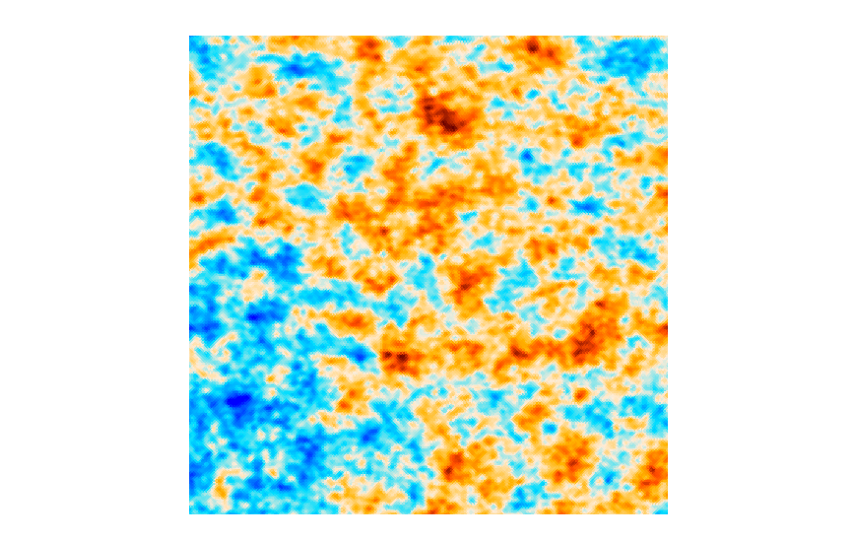

In [48]:
from PIL import Image
image_array = []
import glob
cv = '_cv'
# cv = '_mollview'
files = sorted(glob.glob(r"output/movie/figs/fig*_cv.png")) if cv == '_cv' else sorted(glob.glob(r"output/movie/figs/fig*_mollview.png"))
for my_file in list([*files[:nmax], *files[:nmax][::-1]]):
    
    image = Image.open(my_file)
    image_array.append(image)

print('image_arrays shape:', np.array(image_array).shape)

# Create the figure and axes objects
fig, ax = plt.subplots()
fig.set_size_inches(10.8, 8.7)
# Set the initial image
im = ax.imshow(image_array[0], animated=True, aspect=1, cmap=planck_cmap)
ax.axis('off')

def update(i):
    im.set_array(image_array[i])
    im.set_cmap(planck_cmap)
    clear_output()
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=1, blit=True,repeat_delay=0)
# Show the animation
# plt.show()

animation_fig.save("output/movie/animated_deflection{}.gif".format(cv))
# from IPython.display import HTML
# HTML(animation_fig.to_jshtml())

25


[]

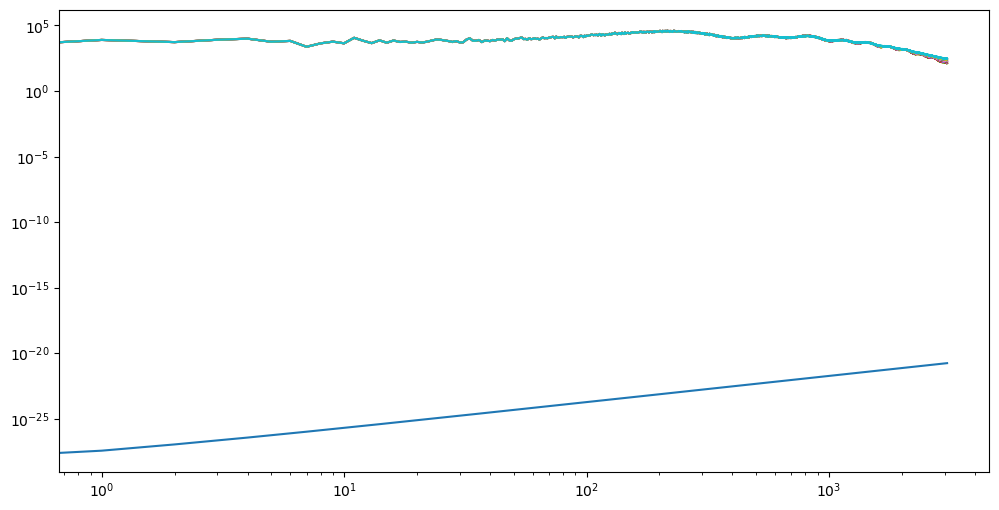

In [76]:
ll = np.arange(0,lmax+1)
# diff = np.array([np.abs(np.mean((gclms[0][0]-gclm[0])/gclm[0])) for gclmi, gclm in enumerate(gclms[1:])])
# plt.plot(diff)
# # plt.loglog()
# plt.show()
print(len(gclms))
fig, ax = plt.subplots(figsize=(12,6))
for gclmi, gclm in enumerate(gclms[:10]):
    # if gclmi in [0,59,60,61]:
    plt.plot(gclm[0]*ll*(ll+1))
plt.loglog()
# plt.ylim(-0.5,0.5)
# plt.xlim(0,500)

In [60]:
len(gclms)

241

In [53]:
gclms[0]

array([2.99964359e-28, 6.28424826e+03, 2.04937976e+03, ...,
       3.56932828e-04, 3.43735959e-04, 3.33270164e-04])

In [1]:
_ptg = get_ptg()

fig, ax = plt.subplots(figsize=(16,16))
mincut, maxcut = None, None
spacing = 128
plt.scatter(_ptgpnod[mincut:maxcut][::spacing], _ptgtnod[mincut:maxcut][::spacing], s=50, marker='s', alpha=0.2, edgecolor='black')
plt.scatter(_ptg[:,1][mincut:maxcut][::spacing], _ptg[:,0][mincut:maxcut][::spacing], s=20)

# spacing = 1
# for x,y,dx,dy in zip(_ptgpnod[::spacing], _ptgtnod[::spacing], (ptgpslice-_ptgpnod)[::spacing], (ptgtslice-_ptgtnod)[::spacing]):
    # plt.arrow(x, y, dx, dy, length_includes_head=True, head_width=2e-4, width=1e-5)#dx, dy)# head_width=0.0000000005)

# plt.xlim(0.8,0.84)
# plt.ylim(0.80,0.84)
# plt.xlim(1.7,2.3)
# plt.ylim(1.7,2.3)


NameError: name 't' is not defined

In [ ]:
_t, _p = t.dlm2pointing(toydlm*1e-12, mmax_dlm=2047, single_prec=False, nthreads=10).T
ptgpslice = (_p.reshape(lmax+1,-1)+0.001*np.sin(100*np.linspace(0,np.pi,2048)).reshape(-1, 1)).flatten()
ptgtslice = (_t.reshape(lmax+1,-1)+0.001*np.sin(100*np.linspace(0,np.pi,4096))).flatten()

ptgtslice = np.where(ptgtslice>np.pi,ptgtslice-np.pi, ptgtslice)
ptgtslice = np.where(ptgtslice<0,ptgtslice+np.pi, ptgtslice)
ptgpslice = np.where(ptgpslice>2*np.pi,ptgpslice-2*np.pi, ptgpslice)
ptgpslice = np.where(ptgpslice<0,ptgpslice+2*np.pi, ptgpslice)

_ptg = np.array([ptgtslice, ptgpslice]).T
ptg.shape, _ptg.shape

In [ ]:
import cunusht

kwargs = {
    'geominfo_deflection':  ('gl',{'lmax':2047}),
    'epsilon':              1e-4,
    'nuFFTtype':            2,
}
t = cunusht.get_transformer(backend='GPU')(**kwargs)

# load jupiter (Planet)

Shape of the NumPy array: (2048, 4096)


/tmp/ipykernel_575622/889345072.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image_gray.resize(new_size, Image.ANTIALIAS)


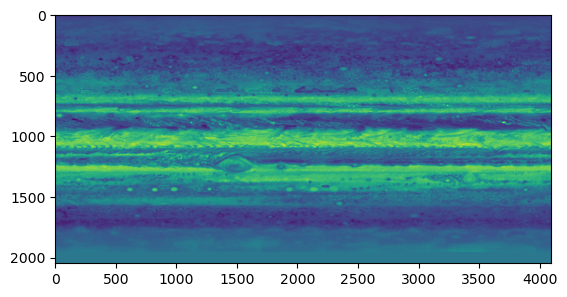

In [2]:
from PIL import Image
import numpy as np

def load_and_interpolate_image(file_path, new_size):
    # Open the image file
    image = Image.open(file_path)
    
    # Convert the image to grayscale
    image_gray = image.convert('L')
    
    # Resize the image to the desired size using interpolation
    resized_image = image_gray.resize(new_size, Image.ANTIALIAS)
    
    # Convert the image to a NumPy array
    numpy_array = np.array(resized_image)
    
    return numpy_array

def load_and_interpolate_image_color(file_path, new_size):
    # Open the image file
    image = Image.open(file_path)
    
    # Resize the image to the desired size using interpolation
    resized_image = image.resize(new_size, Image.ANTIALIAS)
    
    # Convert the image to a NumPy array
    numpy_array = np.array(resized_image)
    
    return numpy_array

# Example usage
file_path = "/mnt/home/sbelkner/git/cunuSHT/dev/jupiter.jpeg"
new_size = (4096, 2048)  # Define the desired size
image_array = load_and_interpolate_image(file_path, new_size)

# Print the shape of the resulting NumPy array
print("Shape of the NumPy array:", image_array.shape)

plt.imshow(image_array)


In [3]:
jupcf = t.lenspyx_geom.adjoint_synthesis(np.atleast_2d(image_array.flatten().astype(np.float64)), spin=0, lmax=lmax, mmax=mmax, nthreads=10)
jupitermap = image_array.flatten().astype(np.float64)

[]

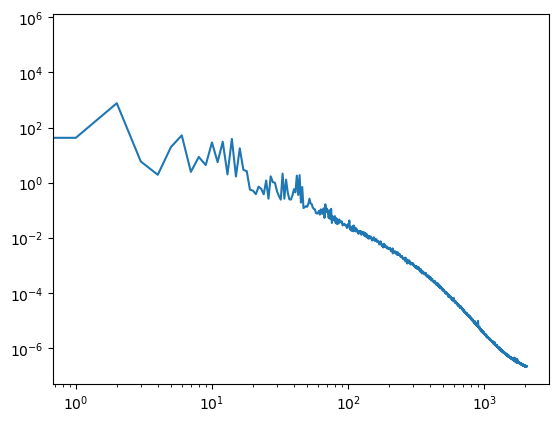

In [84]:
plt.plot(hp.alm2cl(jupcf[0]))
plt.loglog()

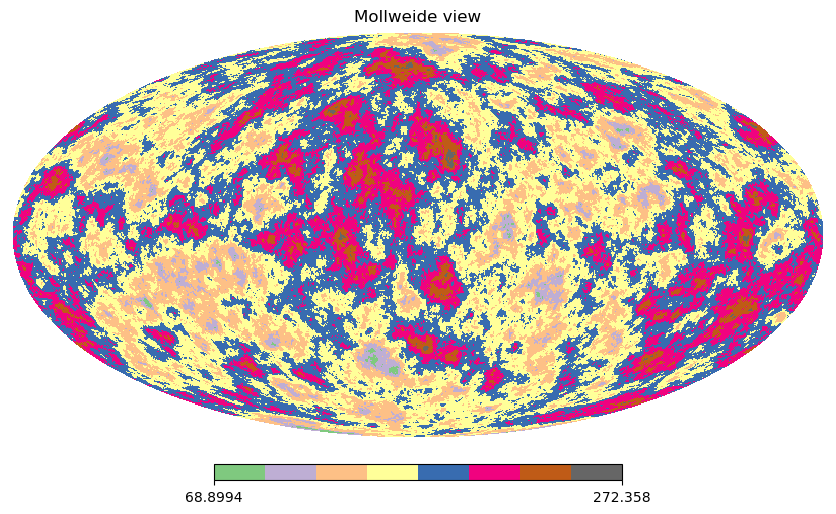

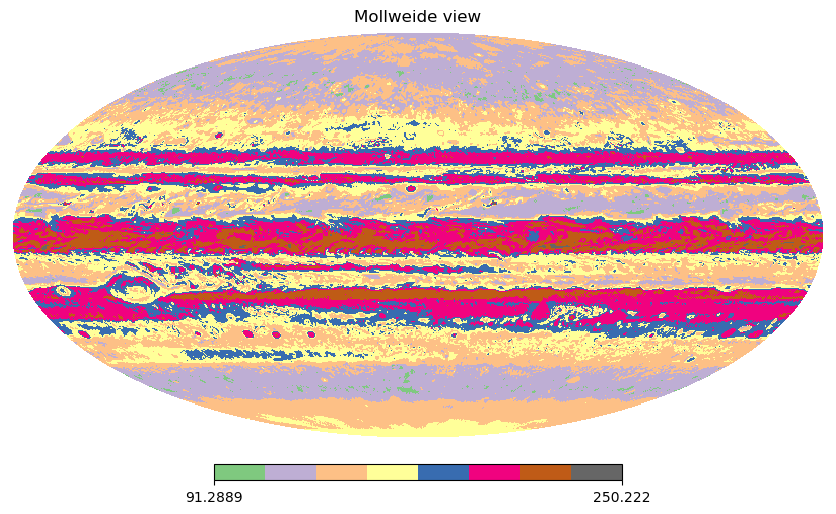

[]

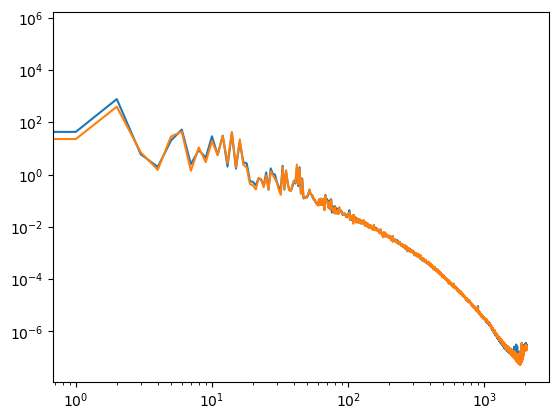

In [106]:
cmap = 'Accent'
cl = hp.alm2cl(jupcf[0])
synfast = hp.synfast(cl, nside=512, lmax=2047)
hp.mollview(synfast, cmap=cmap)
plt.show()
gjm = hp.alm2map(jupcf[0], nside=512)
hp.mollview(gjm, cmap=cmap)
plt.show()
plt.plot(hp.anafast(gjm, lmax=2047))
plt.plot(hp.anafast(synfast, lmax=2047))
plt.loglog()